<a href="https://colab.research.google.com/github/prabhanshu11/Python-for-data-analysis-and-visualisation/blob/master/Lesson_1_Endangered_rodents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai.vision import *
from fastai import *

## Making folders



In [0]:
def FileFolder(name):
  global folder, file
  folder = str(name)
  file = str(name) + '.csv'
  print(f"Folder name = {folder};     File name = {file}")

In [3]:
FileFolder('aadvark')

Folder name = aadvark;     File name = aadvark.csv


In [8]:
FileFolder('pangolin')

Folder name = pangolin;     File name = pangolin.csv


In [11]:
FileFolder('armadillo')

Folder name = armadillo;     File name = armadillo.csv


In [14]:
FileFolder('spiny_anteater')

Folder name = spiny_anteater;     File name = spiny_anteater.csv


In [17]:
FileFolder('giant_anteater')

Folder name = giant_anteater;     File name = giant_anteater.csv


In [18]:
%cd /home
# %mkdir data
path = Path('data/')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

/home


## Downloading files

In [0]:
classes = ['aadvark', 'armadillo', 'pangolin', 'giant_anteater', 'spiny_anteater']


In [0]:
download_images(path/file, dest, max_pics=50)

In [0]:
#removing images which can't be opened
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

## View images

In [0]:
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [0]:
data.classes

['aadvark', 'armadillo', 'giant_anteater', 'pangolin', 'spiny_anteater']

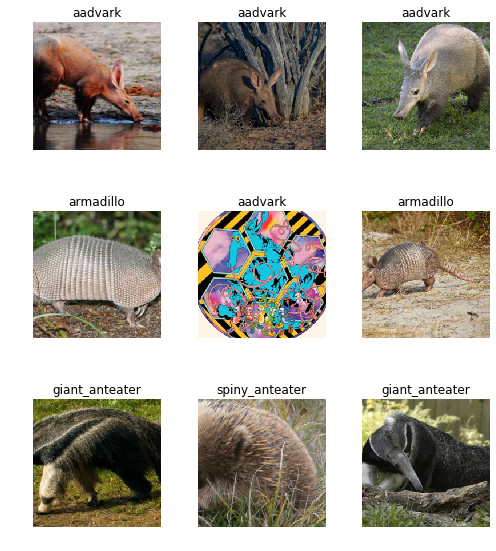

In [23]:

data.show_batch(rows=3, figsize=(7,8))

In [24]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['aadvark', 'armadillo', 'giant_anteater', 'pangolin', 'spiny_anteater'],
 5,
 181,
 45)

## Train data

In [25]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 92414608.32it/s]


In [26]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.060684,1.569574,0.644444,00:06
1,1.602276,0.598436,0.133333,00:03
2,1.168601,0.337189,0.044444,00:03
3,0.907627,0.261946,0.022222,00:03


In [0]:
learn.save('stage-1')
learn.unfreeze()

In [0]:
learn.load('stage-1') ; learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


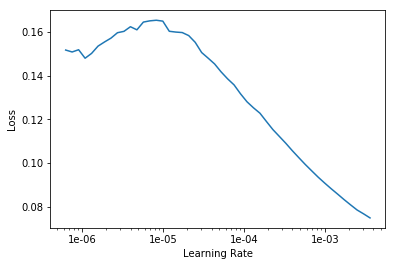

In [39]:
learn.lr_find()
learn.recorder.plot()

In [43]:
learn.fit_one_cycle(2, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.234373,0.213593,0.022222,00:04
1,0.156533,0.188731,0.022222,00:03


In [0]:
learn.save('stage-2')

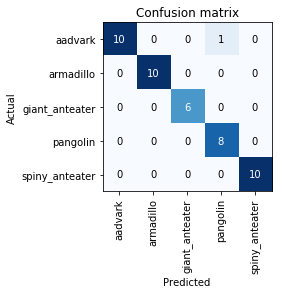

In [47]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused()
interp.plot_confusion_matrix()

## Cleaning Up

In [0]:
from fastai.widgets import *
losses, idxs = interp.top_losses()
top_loss_paths = data.valid_ds.x[idxs]

# production


In [0]:
learn.export()

In [0]:
defaults.device = torch.device('cpu')

learn = load_learner(path)
pred_class, pred_idx, outputs = learn.predict(img)
pred_class

In [59]:
% pip install starlette uvicorn

     |████████████████████████████████| 51kB 2.0MB/s 
     |████████████████████████████████| 61kB 4.8MB/s 
     |████████████████████████████████| 81kB 6.4MB/s 
     |████████████████████████████████| 112kB 47.4MB/s 
     |████████████████████████████████| 3.8MB 41.3MB/s 
  Created wheel for starlette: filename=starlette-0.12.9-cp36-none-any.whl size=57244 sha256=7a814d49549061cf47daec56d6ad05d5d756f109f2eab69c3b666c790dc1fa40
  Stored in directory: /root/.cache/pip/wheels/1c/51/5b/3828d52e185cafad941c4291b6f70894d0794be28c70addae5
  Created wheel for uvicorn: filename=uvicorn-0.9.0-cp36-none-any.whl size=37118 sha256=87343e0eb2d74c73221b68f48e1dcfad0ff42b84398f9ee1c9ad235686def776
  Stored in directory: /root/.cache/pip/wheels/19/e5/d1/a50d405d3bb18fac538ef9606ed9b6cd5efb6e06b6de834507
  Created wheel for httptools: filename=httptools-0.0.13-cp36-cp36m-linux_x86_64.whl size=212550 sha256=2826d5ee1edb2ea6e2c2c724114c59316257d11b309dd8796d6c3608c55fccf8
  Stored in directory: /root/.ca

In [0]:
from starlette.applications import Starlette
from starlette.responses import JSONResponse
import uvicorn

app = Starlette(debug=True)

In [0]:
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })